In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools

# Data directories

In [2]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'

# Load adhesome data

In [3]:
# Load components
components_filename = 'components.csv'
df_components = pd.read_csv(dir_adhesome+components_filename, sep = ',', header = 0)
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82


,Official Symbol,Gene ID,Protein name,Swiss-Prot ID,Synonyms,Functional Category,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


In [8]:
df_components[['Official Symbol']].to_csv(dir_adhesome+'tmp.csv', header=None, index=None, sep=',')

In [12]:
# List of intrinsic components
intrinsic_comps = np.sort(df_components[df_components['FA']=='Intrinsic Proteins']['Official Symbol'].values)
# List of associated components
associated_comps = np.sort(df_components[df_components['FA']=='Associated Proteins']['Official Symbol'].values)

In [13]:
# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
print('Number of interactions: '+str(len(df_interactions)))
df_interactions.head()

Number of interactions: 6542


,Source,Target,Effect,Type,PMID,data_source
0,LPXN,GIT1,0,Binding,12674328,adhesome.org
1,GIT1,ARF1,_,Inhibition,10896954,adhesome.org
2,ARPC2,CTTN,0,Binding,11018051,adhesome.org
3,INSR,PTPN6,+,Activation,7512963,adhesome.org
4,ACTB,TLN1,0,Binding,2121138,adhesome.org


In [14]:
# Construct dataframe of interactions among intrinsic proteins
df_interactions_intrinsic = df_interactions[df_interactions['Source'].isin(intrinsic_comps) & 
                                            df_interactions['Target'].isin(intrinsic_comps)]
print('Number of interaction between intrinsic components: '+str(len(df_interactions_intrinsic)))
df_interactions_intrinsic.head()

Number of interaction between intrinsic components: 2788


,Source,Target,Effect,Type,PMID,data_source
0,LPXN,GIT1,0,Binding,12674328,adhesome.org
4,ACTB,TLN1,0,Binding,2121138,adhesome.org
6,INPPL1,SRC,+,Activation,12235291,adhesome.org
9,LASP1,PALLD,0,Binding,16492705,adhesome.org
10,PAK1,PLCG1,0,Binding,12085993,adhesome.org


In [15]:
# Load predictions obtained from adhesome.org classifier on Harmonizome datasets
predictions_filename = 'predictions.csv'
df_predictions = pd.read_csv(dir_adhesome+predictions_filename, sep = ',', header = 0)
print('Number of predictions: '+str(len(df_predictions)))
df_predictions.head()

Number of predictions: 26928


,GeneSym,Known,Out of Fold Prediction,Out of Fold Probability,In Fold Probability,Model
0,NUSAP1,0,0,0.024595,0.027813,associated
1,WEE1,0,0,0.040820,0.036656,associated
2,BUB1B,0,0,0.052495,0.024476,associated
3,ASPM,0,0,0.050891,0.046398,associated
4,TTK,0,0,0.092996,0.039838,associated


# Construct adhesome network

In [16]:
# Create networkX adhesome network without node attributes
adhesome_network = nx.from_pandas_edgelist(df_interactions, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])


In [17]:
# Dictionary of node attributes
node_attributes = {
    df_components['Official Symbol'][i]: {'Gene ID': df_components['Gene ID'][i],
                                         'Protein name': df_components['Protein name'][i],
                                         'Swiss-Prot ID': df_components['Swiss-Prot ID'][i],
                                         'Synonyms': df_components['Synonyms'][i],
                                         'Functional Category': df_components['Functional Category'][i],
                                         'FA': df_components['FA'][i]
                                                        } 
                   for i in range(len(df_components))

}

In [18]:
# Add node attributes to networkx graph
nx.set_node_attributes(adhesome_network, node_attributes)

In [19]:
# Safety check
print(nx.get_node_attributes(adhesome_network, 'FA')['CTTN'])
print(nx.get_edge_attributes(adhesome_network, 'Type')[('LPXN', 'GIT1')])

Intrinsic Proteins
Binding


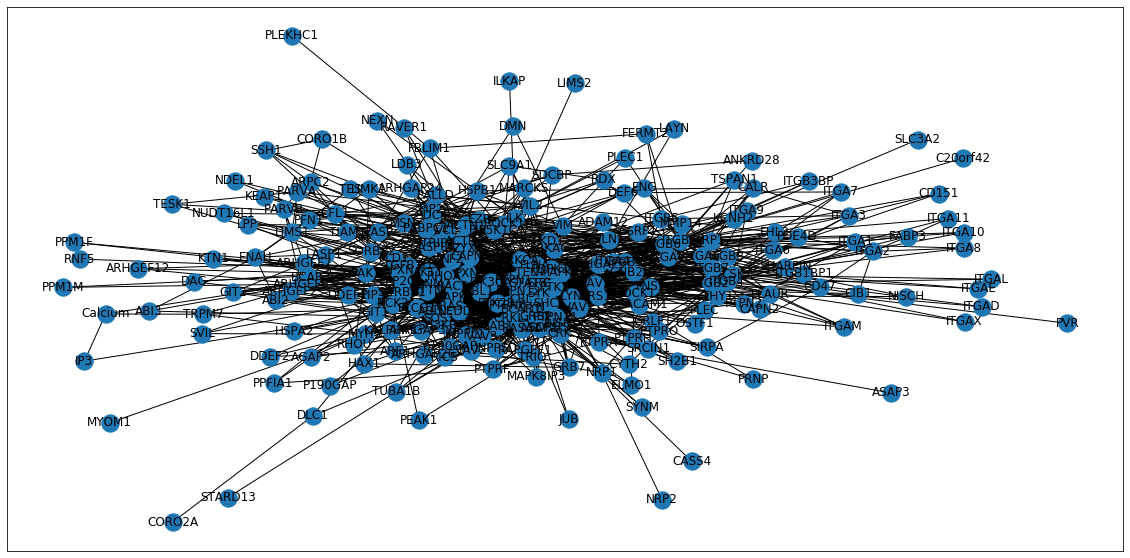

In [20]:
# Plot adhesome network
plt.figure(figsize = (20,10))
nx.draw_networkx(adhesome_network, pos=None, arrows=True, with_labels=True)
plt.show()

# Type and effect of interactions

In [61]:
# Drop duplicate [Source, Target, Effect, Type] rows
df_interactions1 = df_interactions.copy()
df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target','Effect','Type'])
df_interactions1['Type'] = df_interactions1['Type'].str.lower().str.replace('_reaction','')

In [62]:
# All interaction effects
np.unique(df_interactions1.Effect)

array(['+', '0', '_'], dtype=object)

In [63]:
# All interaction types
np.unique(df_interactions1.Type)

array(['activation', 'binding', 'colocalization', 'compound',
       'dephosphorylation', 'direct_interaction', 'enzymatic', 'gef',
       'inhibition', 'phosphorylation', 'unknown'], dtype=object)

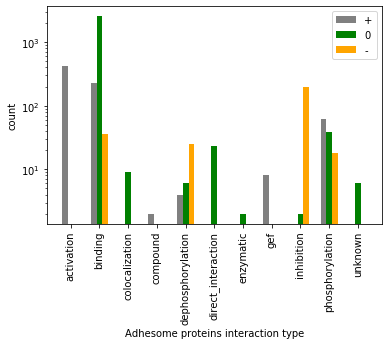

In [64]:
# Barplot of interaction type for each effect
df_interactions1_plus = pd.DataFrame(df_interactions1[df_interactions1['Effect']=='+'].Type.value_counts())
df_interactions1_0 = pd.DataFrame(df_interactions1[df_interactions1['Effect']=='0'].Type.value_counts())
df_interactions1_minus = pd.DataFrame(df_interactions1[df_interactions1['Effect']=='_'].Type.value_counts())
df_bars = df_interactions1_plus.join(df_interactions1_0, how='outer', lsuffix='_plus', rsuffix='_0').join(df_interactions1_minus, how='outer', rsuffix='_minus').fillna(0)
fig = plt.figure()
ax = fig.add_subplot(111)
_x = np.arange(len(df_bars.index))
ax.bar(x = _x-0.2, height = df_bars.Type_plus, color='grey', width=0.2)
ax.bar(x = _x, height = df_bars.Type_0, color='green', width=0.2)
ax.bar(x = _x+0.2, height = df_bars.Type, color='orange', width=0.2)
plt.xticks(_x, list(df_bars.index))
plt.yscale('log')
plt.xlabel('Adhesome proteins interaction type')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.legend(['+', '0', '-'], loc='upper right')
plt.show()